# Topology (Persistent Homology) Detector on Breast Cancer (Tabular)

This notebook demonstrates the **public pipeline API** (`src/api.py`) on the built-in tabular dataset spec:

- Dataset registry key: `breast_cancer_tabular` (see `src/data.py`)
- Model: `MLP` (simple MLP for vector inputs)
- Detector: `detector_type='topology_score'`

Flow:
- load dataset via `api.get_dataset()`
- train model
- generate adversarial examples (FGSM/PGD)
- compute topology features in feature space (local neighborhoods + persistent homology)
- fit detector on validation scores
- evaluate detection metrics on test


In [37]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Ensure repo root on path
import sys
cwd = Path.cwd().resolve()
project_root = cwd if (cwd / "src").is_dir() else (cwd.parent if (cwd.parent / "src").is_dir() else cwd)
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src import api
from src.utils import ExperimentConfig, set_seed
from src.visualization import plot_roc_from_metrics, plot_score_distributions_figure, plot_confusion_matrix

print("PROJECT_ROOT:", project_root)
print("breast_cancer_tabular in registry:", "breast_cancer_tabular" in api.list_datasets())


PROJECT_ROOT: /Users/svenhockers/Desktop/pipeline
breast_cancer_tabular in registry: True


In [38]:
# Config
SEED = 42
set_seed(SEED)

cfg = ExperimentConfig(seed=SEED, device="cpu")

# Training (tabular MLP) — frozen model config
cfg.model.hidden_dims = [128, 64]
cfg.model.epochs = 80
cfg.model.learning_rate = 1e-3
cfg.model.weight_decay = 1e-4
cfg.model.batch_size = 64

# Attack (tabular vectors are standardized by the dataset spec)
# Tip: if attack success rate is ~0, increase epsilon and/or use more PGD steps.
cfg.attack.attack_type = "pgd"  # 'fgsm' or 'pgd'
cfg.attack.epsilon = 0.50
cfg.attack.num_steps = 30
cfg.attack.step_size = cfg.attack.epsilon / 10.0
cfg.attack.random_start = True

# Topology scoring in feature space (penultimate layer only)
cfg.graph.space = "feature"
cfg.graph.feature_layer = "penultimate"

cfg.graph.use_topology = True
cfg.graph.use_tangent = True
cfg.graph.topo_k = 40
cfg.graph.topo_maxdim = 1
cfg.graph.topo_preprocess = "pca"
cfg.graph.topo_pca_dim = 10
cfg.graph.topo_min_persistence = 1e-6

# Detector
cfg.detector.detector_type = "topology_score"
cfg.detector.topo_percentile = 95.0
cfg.detector.topo_cov_shrinkage = 1e-3


Epoch [10/80] Train Loss: 0.0604, Train Acc: 98.53%, Val Loss: 0.0754, Val Acc: 96.49%
Epoch [20/80] Train Loss: 0.0290, Train Acc: 99.12%, Val Loss: 0.0559, Val Acc: 98.25%
Epoch [30/80] Train Loss: 0.0157, Train Acc: 99.71%, Val Loss: 0.0517, Val Acc: 98.25%
Epoch [40/80] Train Loss: 0.0087, Train Acc: 99.71%, Val Loss: 0.0565, Val Acc: 98.25%
Early stopping at epoch 41
Detector threshold: 3.0788342969903773
Val attack success rate: 0.6929824561403509
Test attack success rate: 0.6403508771929824


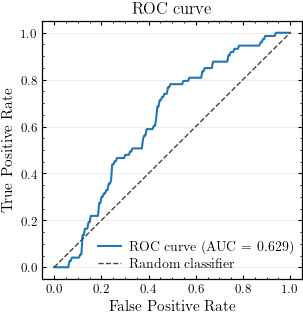

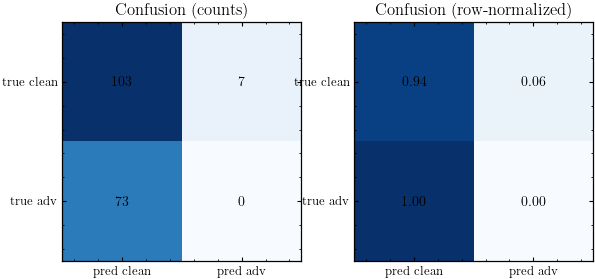

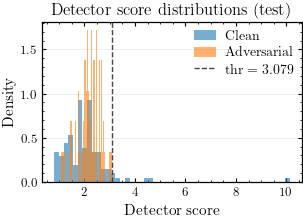

In [39]:
# Run end-to-end pipeline
# - filter_clean_to_correct: calibrate detector only on correctly-classified clean points
# - eval_only_successful_attacks: evaluate detection on successful attacks; falls back to all-adv if none succeed
# - max_points_for_scoring: subsample points for PH runtime

out = api.run_pipeline(
    dataset_name="breast_cancer_tabular",
    model_name="MLP",
    cfg=cfg,
    filter_clean_to_correct=True,
    eval_only_successful_attacks=True,
    max_points_for_scoring=400,
    seed=SEED,
)

print("Detector threshold:", float(out.detector.threshold))
print("Val attack success rate:", out.attack_val.meta.get("success_rate"))
print("Test attack success rate:", out.attack_test.meta.get("success_rate"))


In [40]:
# Metrics summary
metrics = out.eval.metrics

print("AUROC:", metrics.get("roc_auc"))
print("AUPRC:", metrics.get("pr_auc"))
print("FPR@95TPR:", metrics.get("fpr_at_95_tpr"))
print("Accuracy (thr):", metrics.get("accuracy"))
print("Balanced acc (thr):", metrics.get("balanced_accuracy"))


AUROC: 0.6286425902864259
AUPRC: 0.46126463932354733
FPR@95TPR: None
Accuracy (thr): 0.5628415300546448
Balanced acc (thr): None


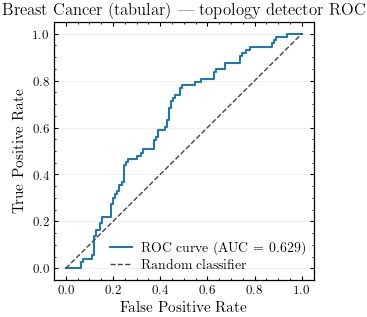

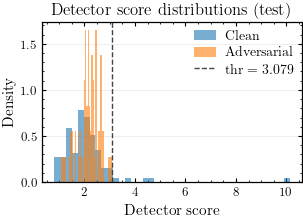

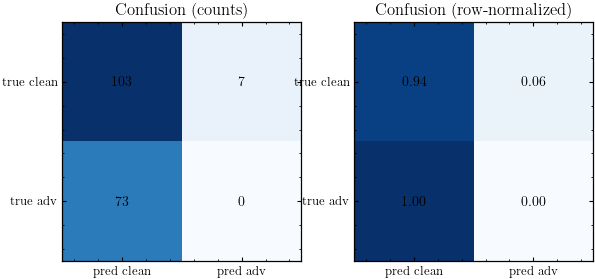

In [41]:
# Plots
_ = plot_roc_from_metrics(metrics, title="Breast Cancer (tabular) — topology detector ROC", show=True)

thr = float(out.detector.threshold)

s_clean = np.asarray(out.detector.score(out.scores_test_clean), dtype=float)
s_adv = np.asarray(out.detector.score(out.scores_test_adv), dtype=float)
_ = plot_score_distributions_figure(
    s_clean,
    s_adv,
    score_name="Detector score",
    title="Detector score distributions (test)",
    bins=40,
    threshold=thr,
    show=True,
)

_ = plot_confusion_matrix(out.eval.labels, y_scores=out.eval.raw_scores, threshold=thr, show=True)
